# Flatness v.s. Generalization

# PART 1

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [8]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
def train_model(model, optimizer, loss_fn, train_loader, epochs=5):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total_loss = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        accuracy = 100 * correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies


In [12]:
def test_model(model, data_loader, loss_fn):
    model.eval()
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in data_loader:
            output = model(images)
            loss = loss_fn(output, labels)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

    accuracy = 100 * correct / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, accuracy


In [10]:
def interpolate_and_record(model1, model2, alpha, train_loader, test_loader, loss_fn):
    interpolated_model = SimpleNN()
    with torch.no_grad():
        for param1, param2, param_interpolated in zip(model1.parameters(), model2.parameters(), interpolated_model.parameters()):
            param_interpolated.data = (1 - alpha) * param1.data + alpha * param2.data

    train_loss, train_acc = test_model(interpolated_model, train_loader, loss_fn)
    test_loss, test_acc = test_model(interpolated_model, test_loader, loss_fn)
    
    return train_loss, train_acc, test_loss, test_acc


In [13]:
model1 = SimpleNN()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_losses1, train_accuracies1 = train_model(model1, optimizer1, loss_fn, train_loader)


Epoch [1/5], Loss: 0.3588, Accuracy: 90.27%
Epoch [2/5], Loss: 0.1684, Accuracy: 95.17%
Epoch [3/5], Loss: 0.1156, Accuracy: 96.66%
Epoch [4/5], Loss: 0.0870, Accuracy: 97.42%
Epoch [5/5], Loss: 0.0687, Accuracy: 97.93%


In [14]:
model2 = SimpleNN()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-2)
train_losses2, train_accuracies2 = train_model(model2, optimizer2, loss_fn, train_loader)


Epoch [1/5], Loss: 0.2243, Accuracy: 93.15%
Epoch [2/5], Loss: 0.1275, Accuracy: 96.21%
Epoch [3/5], Loss: 0.1077, Accuracy: 96.75%
Epoch [4/5], Loss: 0.1025, Accuracy: 97.08%
Epoch [5/5], Loss: 0.0889, Accuracy: 97.48%


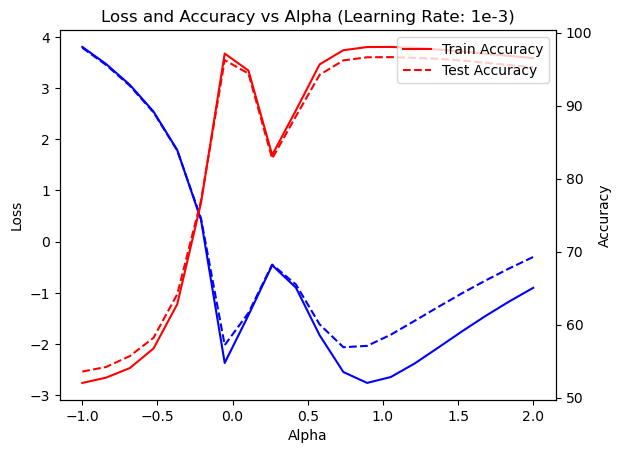

In [17]:
alphas = torch.linspace(-1.0, 2.0, 20).tolist()
train_losses_interpolated = []
test_losses_interpolated = []
train_accuracies_interpolated = []
test_accuracies_interpolated = []

for alpha in alphas:
    train_loss, train_acc, test_loss, test_acc = interpolate_and_record(model1, model2, alpha, train_loader, test_loader, loss_fn)
    train_losses_interpolated.append(train_loss)
    test_losses_interpolated.append(test_loss)
    train_accuracies_interpolated.append(train_acc)
    test_accuracies_interpolated.append(test_acc)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alphas, np.log(train_losses_interpolated), 'b', label='Train Los')
ax1.plot(alphas, np.log(test_losses_interpolated), 'b--', label='Test Loss')
ax2.plot(alphas, train_accuracies_interpolated, 'r', label='Train Accuracy')
ax2.plot(alphas, test_accuracies_interpolated, 'r--', label='Test Accuracy')

ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax1.set_title('Loss and Accuracy vs Alpha (Learning Rate: 1e-3)')
plt.legend(loc='upper right')
plt.show()


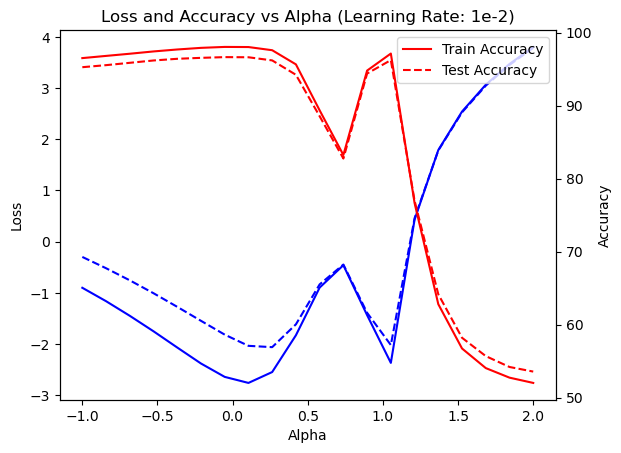

In [18]:
train_losses_interpolated.clear()
test_losses_interpolated.clear()
train_accuracies_interpolated.clear()
test_accuracies_interpolated.clear()


for alpha in alphas:
    train_loss, train_acc, test_loss, test_acc = interpolate_and_record(model2, model1, alpha, train_loader, test_loader, loss_fn)
    train_losses_interpolated.append(train_loss)
    test_losses_interpolated.append(test_loss)
    train_accuracies_interpolated.append(train_acc)
    test_accuracies_interpolated.append(test_acc)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alphas, np.log(train_losses_interpolated), 'b', label='Train Loss')
ax1.plot(alphas, np.log(test_losses_interpolated), 'b--', label='Test Loss')
ax2.plot(alphas, train_accuracies_interpolated, 'r', label='Train Accuracy')
ax2.plot(alphas, test_accuracies_interpolated, 'r--', label='Test Accuracy')

ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax1.set_title('Loss and Accuracy vs Alpha (Learning Rate: 1e-2)')
plt.legend(loc='upper right')
plt.show()
